In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/Data-Analysis-Projects/Credit_Card_Fraud_Detection


## Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
classification_report, confusion_matrix, precision_recall_curve, \
average_precision_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
import lightgbm as lgb
from lightgbm import LGBMClassifier
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Custom Functions
import curves as C

In [0]:
dataset = pd.read_csv('creditcard.csv')
dataset_X = dataset.drop(['Class'], axis = 1)
dataset_y = dataset['Class']

## Splitting the dataset into the Training set and Test set

In [0]:
def split_data(X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
    print('train-set size: ', len(y_train), 
          '\ntest-set size: ', len(y_test))    
    print('fraud cases in train-set', sum(y_train),
          '\nfraud cases in test-set: ', sum(y_test))
    return X_train, X_test, y_train, y_test

## Define function to get predictions

In [0]:
def get_predictions(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    sns.heatmap(cm, cmap = "coolwarm", annot = True, linewidths = 0.5)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("Real class")
    plt.show()
    
    print('==============================')
    print(cm)
    print('==============================')
    print('accuracy = {}'.format(accuracy))
    print('precision = {}'.format(precision))
    print('recall = {}'.format(recall))
    print('f1 score = {}'.format(f1))
    print('==============================')
    print(classification_report(y_true, y_pred))

## Feature importance plot

In [0]:
def plot_feature_importance(model, predictors):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by = 'Feature importance', ascending = False)
    plt.figure(figsize = (15, 8))
    plt.title('Features importance', fontsize = 14)
    s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
    s.set_xticklabels(s.get_xticklabels(), rotation = 45)
    plt.show()

## Case 1: Drop 'Time', 'Amount'

In [9]:
drop_list = ['Time', 'Amount']
# drop_list = ['Time', 'Amount', 'V28', 'V27', 'V26', 'V25', 'V24', 'V23', 'V22', 'V20', 'V15', 'V13', 'V8']
X = dataset_X.drop(drop_list, axis = 1)
predictor_name = X.columns
X = X.values
y = dataset_y.values
print(predictor_name)
X_train, X_test, y_train, y_test = split_data(X, y)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')
train-set size:  199364 
test-set size:  85443
fraud cases in train-set 384 
fraud cases in test-set:  108


 ## 1. LightGBM

### 1.1 LightGBM - Without hyperparameters tuning

In [10]:
'''
param_lgb = {
            'bagging_fraction': 0.8082060379239122,
            'colsample_bytree': 0.4236846658378094,
            'feature_fraction': 0.1622850961512378,
            'learning_rate': 0.24617571597038826,
            'max_depth': 10,
            'min_child_samples': 110.4846966877894,
            'min_child_weight': 0.0077240770377460955,
            'min_data_in_leaf': 16,
            'num_leaves': 8,
            'reg_alpha': 0.6051612648874549,
            'reg_lambda': 97.89699721669824,
            'subsample': 0.20955925262252026,
            'objective': 'binary',
            'save_binary': True,
            'seed': 1337,
            'feature_fraction_seed': 1337,
            'bagging_seed': 1337,
            'drop_seed': 1337,
            'data_random_seed': 1337,
            'boosting_type': 'gbdt',
            'verbose': 1,
            'is_unbalance': False,
            'boost_from_average': True,
            'metric':'auc'}
'''

"\nparam_lgb = {\n            'bagging_fraction': 0.8082060379239122,\n            'colsample_bytree': 0.4236846658378094,\n            'feature_fraction': 0.1622850961512378,\n            'learning_rate': 0.24617571597038826,\n            'max_depth': 10,\n            'min_child_samples': 110.4846966877894,\n            'min_child_weight': 0.0077240770377460955,\n            'min_data_in_leaf': 16,\n            'num_leaves': 8,\n            'reg_alpha': 0.6051612648874549,\n            'reg_lambda': 97.89699721669824,\n            'subsample': 0.20955925262252026,\n            'objective': 'binary',\n            'save_binary': True,\n            'seed': 1337,\n            'feature_fraction_seed': 1337,\n            'bagging_seed': 1337,\n            'drop_seed': 1337,\n            'data_random_seed': 1337,\n            'boosting_type': 'gbdt',\n            'verbose': 1,\n            'is_unbalance': False,\n            'boost_from_average': True,\n            'metric':'auc'}\n"

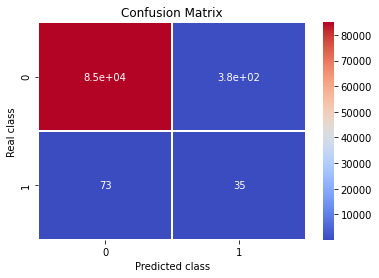

[[84951   384]
 [   73    35]]
accuracy = 0.9946514050302541
precision = 0.08353221957040573
recall = 0.32407407407407407
f1 score = 0.13282732447817835
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.08      0.32      0.13       108

    accuracy                           0.99     85443
   macro avg       0.54      0.66      0.57     85443
weighted avg       1.00      0.99      1.00     85443



In [11]:
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_score = lgbm_clf.predict_proba(X_test)[:,1]
y_pred = lgbm_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

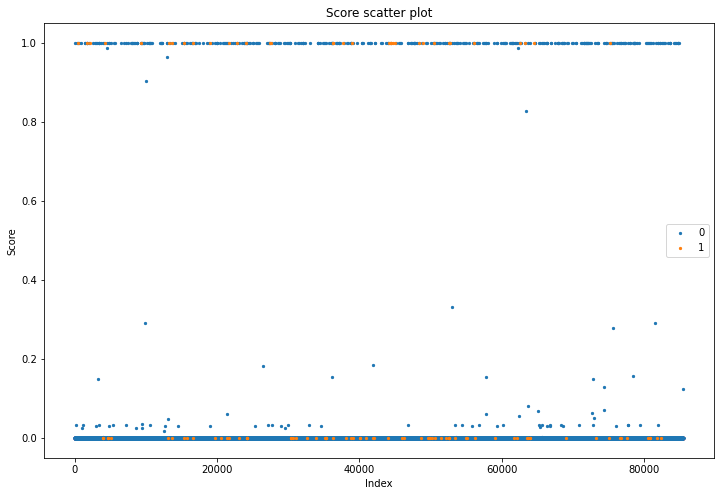

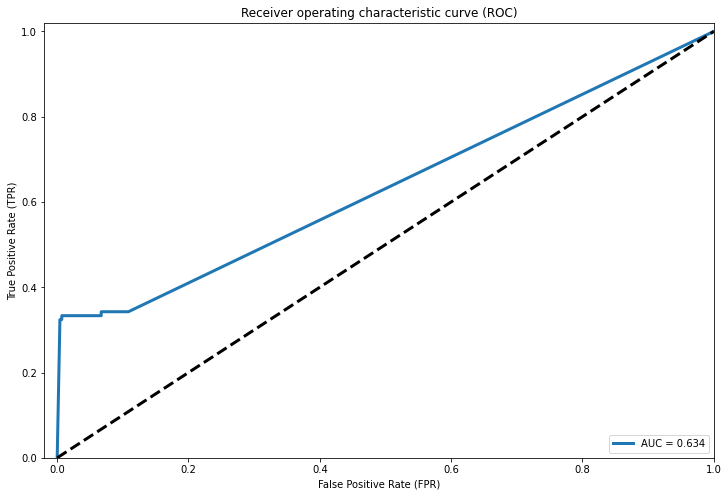

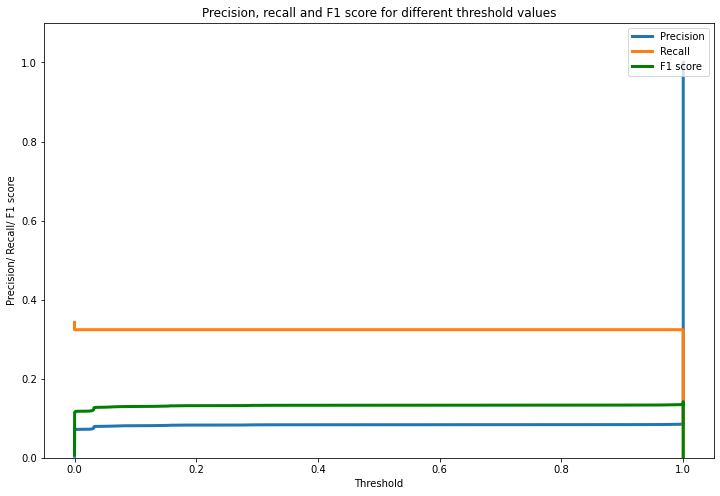

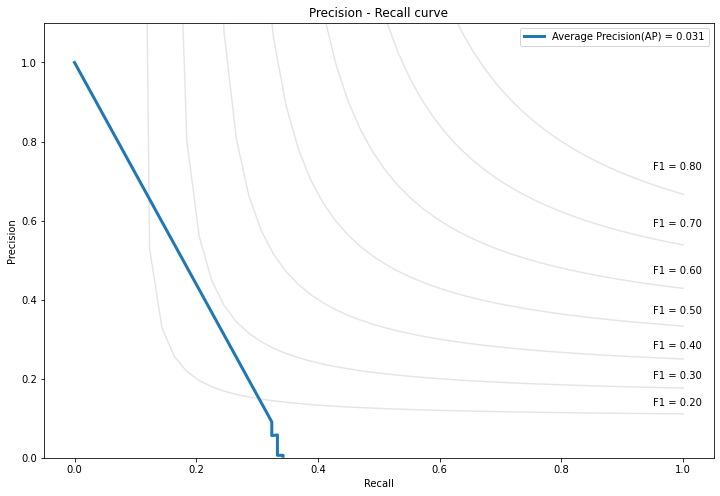

In [12]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_lgbm, tpr_lgbm, roc_auc_lgbm = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_lgbm, recall_lgbm, threshold_lgbm, f1_scores_lgbm = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_lgbm = C.plot_precision_recall(y_true = y_test, y_score = y_score)

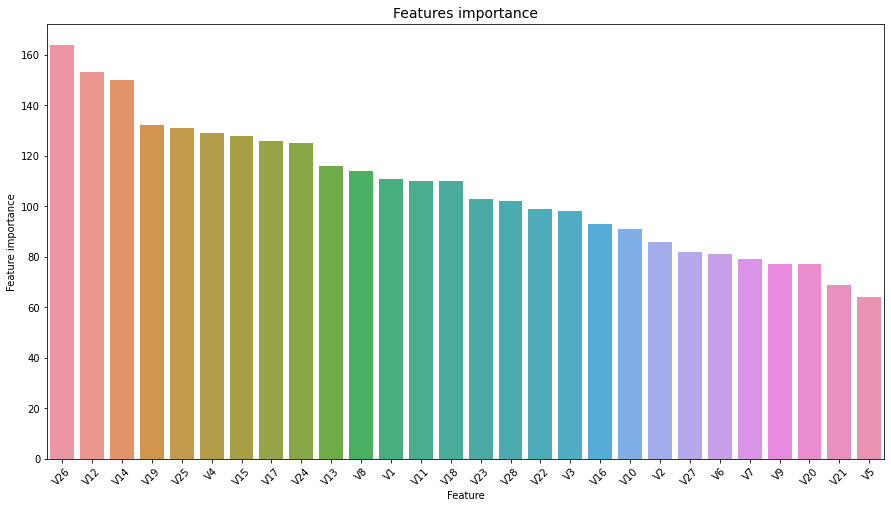

In [0]:
# Plot Feature importance
plot_feature_importance(model = lgbm_clf, predictors = predictor_name)

### 1.2 Grid/Randomized Search CV to optimize 'F1'

#### Applying ***Grid Search*** to find the best model and the best parameters

In [0]:
'''
classifier = LGBMClassifier()
parameter = [{'n_estimators': [100, 200, 300, 400, 500], 
              'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05]}]
skf = StratifiedKFold(n_splits = 5, random_state = 0)
grid_search = GridSearchCV(estimator = classifier, 
                           param_grid = parameter,
                           scoring = 'f1',
                           cv = skf.split(X_train, y_train),
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
results = grid_search.cv_results_
best_parameters
'''

"\nclassifier = LGBMClassifier()\nparameter = [{'n_estimators': [100, 200, 300, 400, 500], \n              'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05]}]\nskf = StratifiedKFold(n_splits = 5, random_state = 0)\ngrid_search = GridSearchCV(estimator = classifier, \n                           param_grid = parameter,\n                           scoring = 'f1',\n                           cv = skf.split(X_train, y_train),\n                           n_jobs = -1)\ngrid_search = grid_search.fit(X_train, y_train)\nbest_score = grid_search.best_score_\nbest_parameters = grid_search.best_params_\nresults = grid_search.cv_results_\nbest_parameters\n"

#### Applying ***Randomized Search***  to find the best model and the best parameters

In [0]:
from scipy.stats import randint
from scipy.stats import uniform

classifier = LGBMClassifier()       
parameter = {'learning_rate' : uniform(loc = 0, scale = 0.1),
             'n_estimators' : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
             'num_leaves': randint(5, 100), 
             'min_child_samples': randint(20, 500), 
             'min_child_weight': uniform(loc = 0, scale = 1000),
             'subsample': uniform(loc = 0, scale = 1), 
             'max_depth': randint(low = -1, high = 11),
             'colsample_bytree': uniform(loc = 0, scale = 1),
             'reg_alpha': uniform(loc = 0, scale = 100),
             'reg_lambda': uniform(loc = 0, scale = 100)}

skf = StratifiedKFold(n_splits = 5, random_state = 0)
rand_search = RandomizedSearchCV(estimator = classifier, 
                                 param_distributions = parameter,
                                 n_iter = 200, 
                                 scoring = 'f1',
                                 cv = skf.split(X_train, y_train),
                                 n_jobs = -1)
tStart = time.time()
rand_search = rand_search.fit(X_train, y_train)
tEnd = time.time()

rand_best_score = rand_search.best_score_
rand_best_parameters = rand_search.best_params_
rand_results = rand_search.cv_results_
print('It costs {:.2f} sec.'.format(tEnd - tStart))
print(rand_best_parameters)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


It costs 4160.86 sec.
{'colsample_bytree': 0.5914306621816168, 'learning_rate': 0.06072545230769029, 'max_depth': -1, 'min_child_samples': 353, 'min_child_weight': 31.90539884546828, 'n_estimators': 100, 'num_leaves': 24, 'reg_alpha': 9.452281385624794, 'reg_lambda': 10.990480792763224, 'subsample': 0.8667548610309412}


In [0]:
rand_best_parameters = {'colsample_bytree': 0.5914306621816168, 
                        'learning_rate': 0.06072545230769029, 
                        'max_depth': -1, 
                        'min_child_samples': 353, 
                        'min_child_weight': 31.90539884546828, 
                        'n_estimators': 100, 
                        'num_leaves': 24, 
                        'reg_alpha': 9.452281385624794, 
                        'reg_lambda': 10.990480792763224, 
                        'subsample': 0.8667548610309412}

### 1.3 LightGBM with best parameters

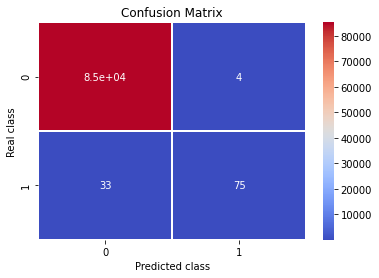

[[85331     4]
 [   33    75]]
accuracy = 0.9995669627705019
precision = 0.9493670886075949
recall = 0.6944444444444444
f1 score = 0.8021390374331551
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.95      0.69      0.80       108

    accuracy                           1.00     85443
   macro avg       0.97      0.85      0.90     85443
weighted avg       1.00      1.00      1.00     85443



In [15]:
lgbm_clf = LGBMClassifier(**rand_best_parameters, n_jobs = -1)
lgbm_clf.fit(X_train, y_train)
y_score = lgbm_clf.predict_proba(X_test)[:,1]
y_pred = lgbm_clf.predict(X_test)
get_predictions(y_true = y_test, y_pred = y_pred)

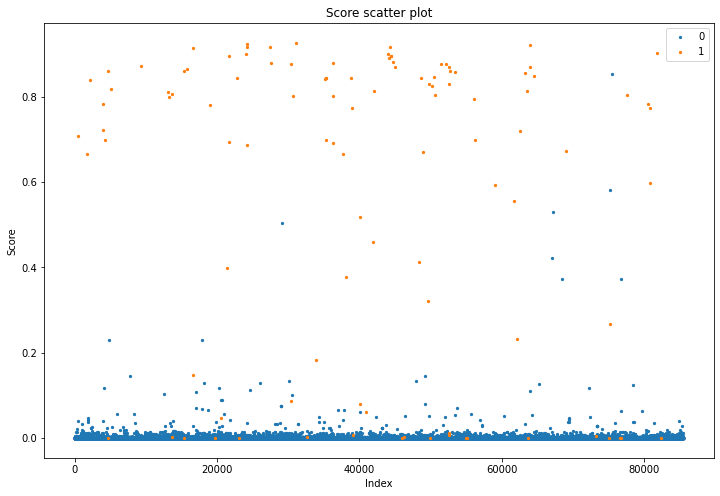

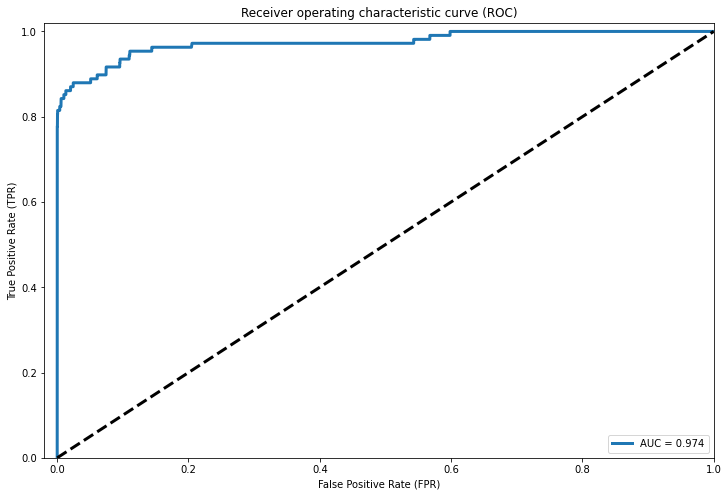

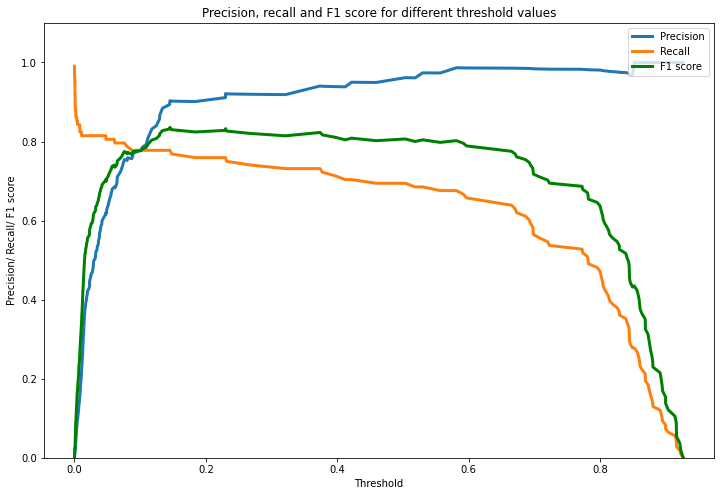

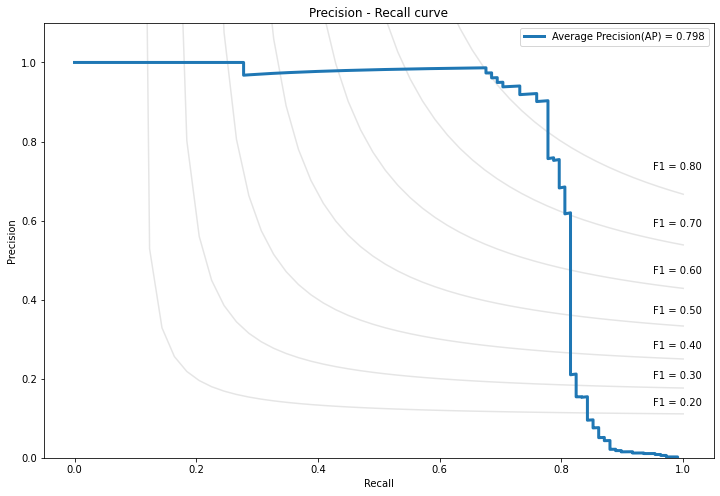

In [16]:
# Plot scores, ROC, Precision, Recall, F1 curve, Precision-Recall curve
C.plot_scores(y_true = y_test, y_score = y_score)
fpr_xgb, tpr_xgb, roc_auc_xgb = C.plot_ROC(y_true = y_test, y_score = y_score)
precision_xgb, recall_xgb, threshold_xgb, f1_scores_xgb = C.plot_precision_recall_vs_threshold(y_true = y_test, y_score = y_score)
_, _, pr_auc_xgb = C.plot_precision_recall(y_true = y_test, y_score = y_score)

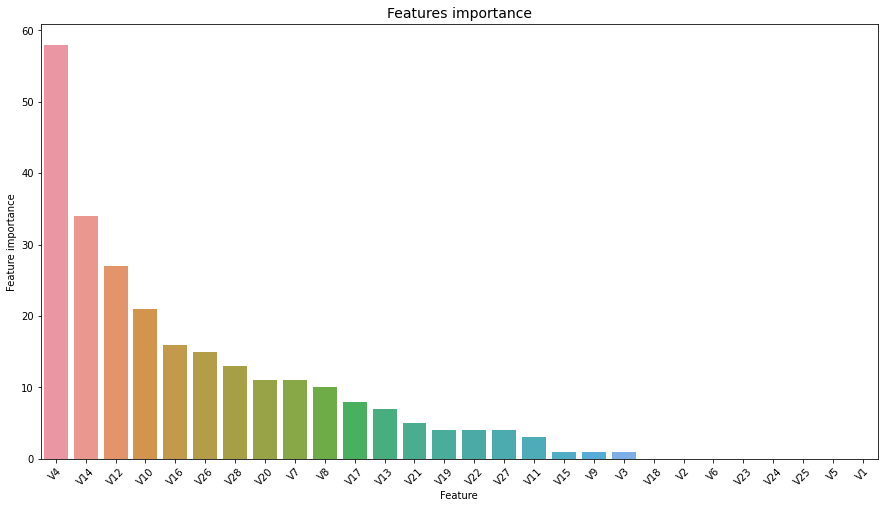

In [17]:
# Plot Feature importance
plot_feature_importance(model = lgbm_clf, predictors = predictor_name)

## Select Threshold By Kfold Cross-Validation

In [0]:
from selectThreshold import selectThresholdByCV
skf = StratifiedKFold(n_splits = 5)
thresholds = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
classifier = LGBMClassifier(**rand_best_parameters, n_jobs = -1)

Split0
Split1


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split2


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Split3
Split4


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


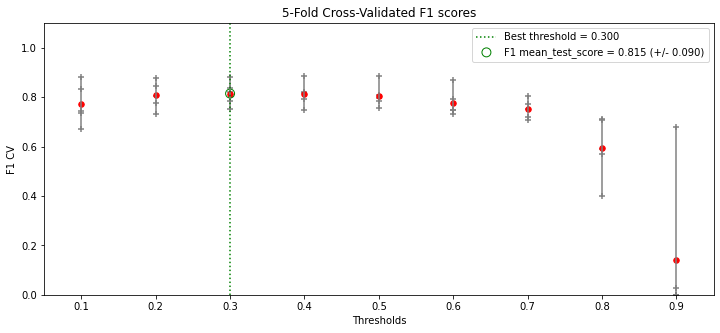

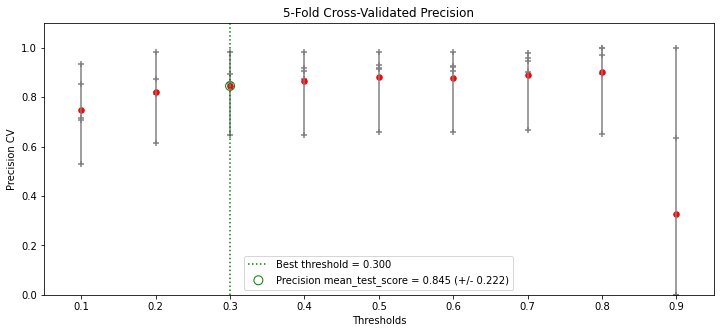

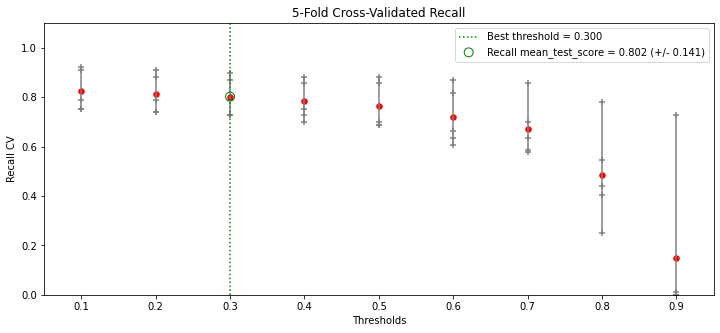

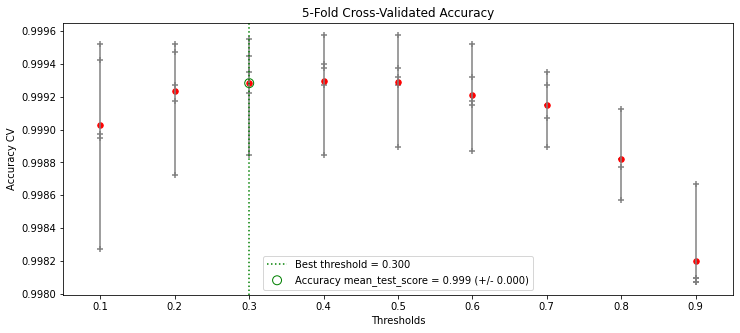

The best threshold = 0.300


In [20]:
best_threshold, best_score, best_std, mean_test_score, std_test_score, cv_results = \
selectThresholdByCV(clf = classifier, 
                    X = X_train, y = y_train, 
                    thresholds = thresholds, 
                    cv = skf, 
                    scoring = 'f1',
                    plot_result = True)
print('The best threshold = %.3f' % (best_threshold))

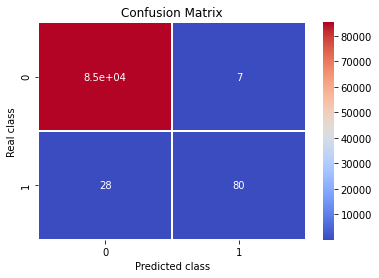

[[85328     7]
 [   28    80]]
accuracy = 0.9995903701883126
precision = 0.9195402298850575
recall = 0.7407407407407407
f1 score = 0.8205128205128205
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85335
           1       0.92      0.74      0.82       108

    accuracy                           1.00     85443
   macro avg       0.96      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [21]:
lgbm_clf = LGBMClassifier(**rand_best_parameters, n_jobs = -1)
lgbm_clf.fit(X_train, y_train)
y_score = lgbm_clf.predict_proba(X_test)[:,1]
y_pred = y_score > 0.3
get_predictions(y_true = y_test, y_pred = y_pred)